Открою датасет sklearn.datasets.load_wine, содержащий информацию о трех различных сортах винаек

In [1]:
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np
import math
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


data = load_wine()

df=pd.DataFrame(data=np.c_[data['data'],data['target']],columns=data['feature_names']+['target'])

Используя файл Sem5_EM.ipynb, модифицирую алгоритм EM 
так, чтобы он умел распознавать три класс (попутно комментирую шаги).Сначала модифицирую вспомогательные функции

In [2]:
# запишем функцию E-шага
def e_step(x, k, m, n, w, mu, sigma):
    # инициализируем массив плотностей вероятностей извлечения i-ой детали из произведенных на j-м станке 
    pj_xi = []
    for j in range(k):
        det_sigma_j = np.linalg.det(sigma[j])
        factor_1 = 1 / (((2 * math.pi)**(k/2)) * ((det_sigma_j)**0.5))
        factor_2 = []
        for i in x:
            factor_2.append(math.e**float(
                -0.5 * np.matrix(i - mu[j]) * np.matrix(np.linalg.inv(sigma[j])) * np.matrix(i - mu[j]).T))
        pj_xi.append(factor_1 * np.array(factor_2))
    pj_xi = np.array(pj_xi)
    
    # инициализируем массив плотностей вероятностей того, что i-я деталь произведена на j-м станке
    pj_xi_w = []
    for j in range(k):
        pj_xi_w.append(pj_xi[j] * w[j])
    pj_xi_w = np.array(pj_xi_w)
    
    # рассчитаем плотность вероятности извлечения i-й детали среди всех деталей  
    sum_pj_xi_w = np.sum(pj_xi_w, axis = 0)
    
    # инициализируем массив вероятностей отнесения каждой детали к каждому станку
    proba_xi = []
    for j in range(k):
        proba_xi.append(pj_xi_w[j] / sum_pj_xi_w)
    
    return np.array(proba_xi)

# запишем функцию, в соответствии с которой, на основании данных о вероятности отнесения изделия к тому или иному станку,
# будет определятся на каком станке изделие производилось
def x_new(proba_xi):
    X1_new_ind = []
    X2_new_ind = []
    X3_new_ind = []
    X_answers = []

    count = 0
    for i in range(len(proba_xi[0])):
        if proba_xi[0][i] >= proba_xi[1][i] and proba_xi[0][i] >= proba_xi[2][i]:
            X1_new_ind.append(count)
            X_answers.append(1)
        elif proba_xi[1][i] >= proba_xi[0][i] and proba_xi[1][i] >= proba_xi[2][i]:
            X2_new_ind.append(count)
            X_answers.append(2)
        else:
            X3_new_ind.append(count)
            X_answers.append(3)
        count += 1
    # на выходе получаем вектор индексов изделий, произведенных на станке №1, №2, №3 и вектор ответов
    return X1_new_ind, X2_new_ind, X3_new_ind, X_answers


# запишем функцию M-шага
def m_step(x, proba_xi,N):
    w_new = np.sum(proba_xi, axis = 1) / N
    
    # рассчитаем математическое ожидание
    mu_new = (np.array((np.matrix(proba_xi) * np.matrix(X))).T / np.sum(proba_xi, axis = 1)).T
    
    # рассчитаем дисперсии
    cov_new = []
    for mu in range(mu_new.shape[0]):
        X_cd = []
        X_cd_proba = []
        count = 0
        for x_i in x:
            cd = np.array(x_i - mu_new[mu])
            X_cd.append(cd)
            X_cd_proba.append(cd * proba_xi[mu][count])
            count += 1
        X_cd = np.array(X_cd)
        X_cd = X_cd.reshape(N, m)
        X_cd_proba = np.array(X_cd_proba)
        X_cd_proba = X_cd_proba.reshape(N, m)

        cov_new.append(np.matrix(X_cd.T) * np.matrix(X_cd_proba))
    cov_new = np.array((np.array(cov_new) / (np.sum(proba_xi, axis = 1)-1)))
    # при расчете матрицы ковариации в некоторых случаях могут быть элементы с отрицательными значениями, переведем их в нули
    # на основной рассчет такой перевод не повлияет, но упростит извлечение корня из значений матрицы ковариации
    for i in range(3):
    # верхняя строка
        if cov_new[i][0][1] < 0:
            cov_new[i][0][1] = 0
        if cov_new[i][0][2] < 0:
            cov_new[i][0][2] = 0
        # средняя строка
        if cov_new[i][1][0] < 0:
            cov_new[i][1][0] = 0
        if cov_new[i][1][2] < 0:
            cov_new[i][1][2] = 0
        # нижняя строка
        if cov_new[i][2][0] < 0:
            cov_new[i][2][0] = 0
        if cov_new[i][2][1] < 0:
            cov_new[i][2][1] = 0
        
        if cov_new[i][1][0] < 0:
            cov_new[i][1][0] = 0
        if cov_new[i][1][2] < 0:
            cov_new[i][1][2] = 0
        
    
    # рассчитаем стандартное отклонение
    sigma_new = cov_new**0.5
    return w_new, mu_new, sigma_new

Теперь перепишем код под наше условие с датасетом load_wine

Итерация № 1
Матрица значений математических ожиданий
[[0.51994964 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]]
Матрица значений стандартных отклонений
[[[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]]
Доля правильно распознанных изделий
0.455


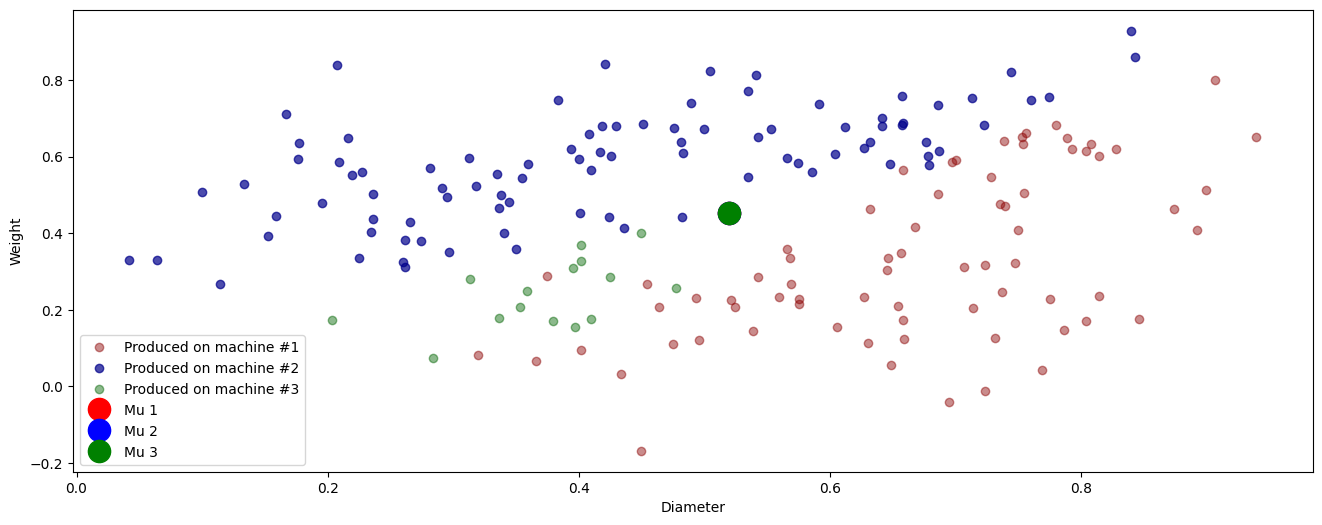

Итерация № 2
Матрица значений математических ожиданий
[[0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]]
Матрица значений стандартных отклонений
[[[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]]
Доля правильно распознанных изделий
0.382


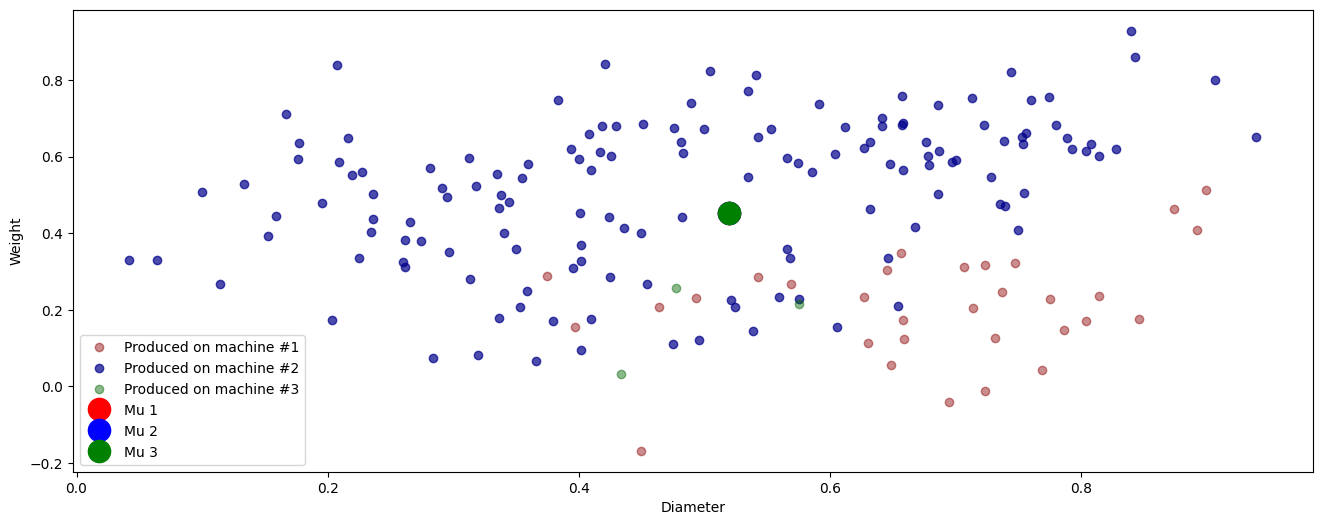

Итерация № 3
Матрица значений математических ожиданий
[[0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]]
Матрица значений стандартных отклонений
[[[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]]
Доля правильно распознанных изделий
0.399


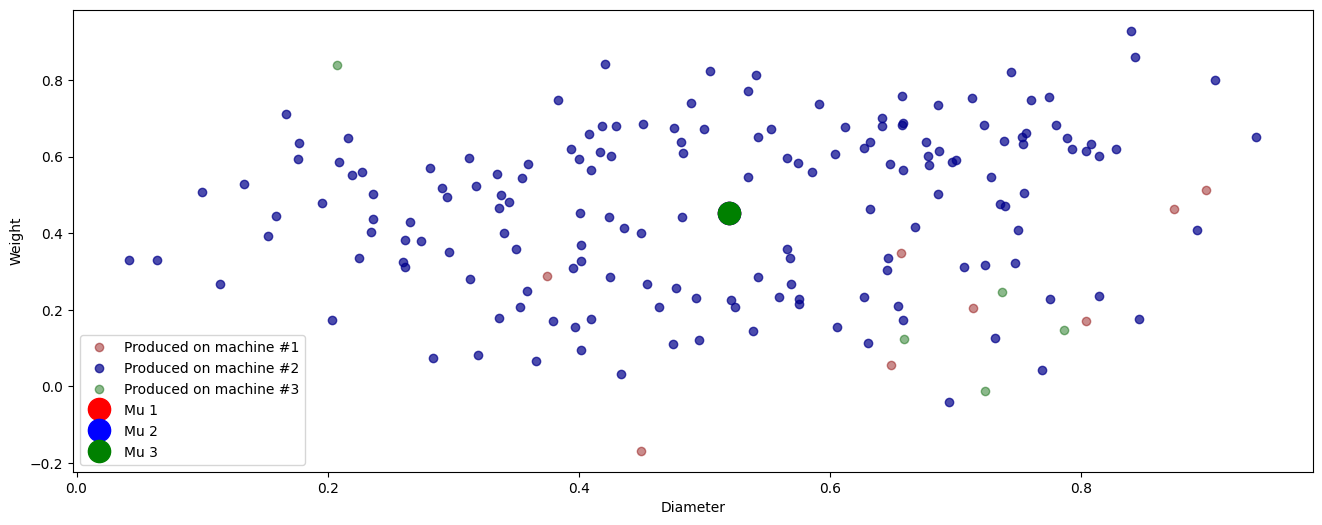

Итерация № 4
Матрица значений математических ожиданий
[[0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]]
Матрица значений стандартных отклонений
[[[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]]
Доля правильно распознанных изделий
0.399


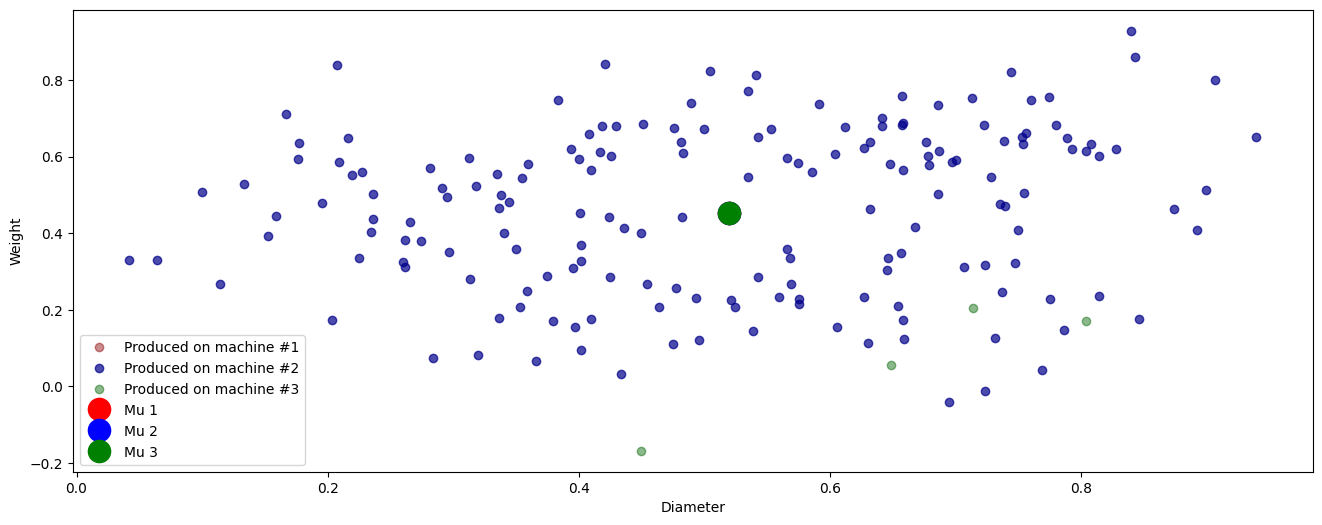

Итерация № 5
Матрица значений математических ожиданий
[[0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]]
Матрица значений стандартных отклонений
[[[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]]
Доля правильно распознанных изделий
0.399


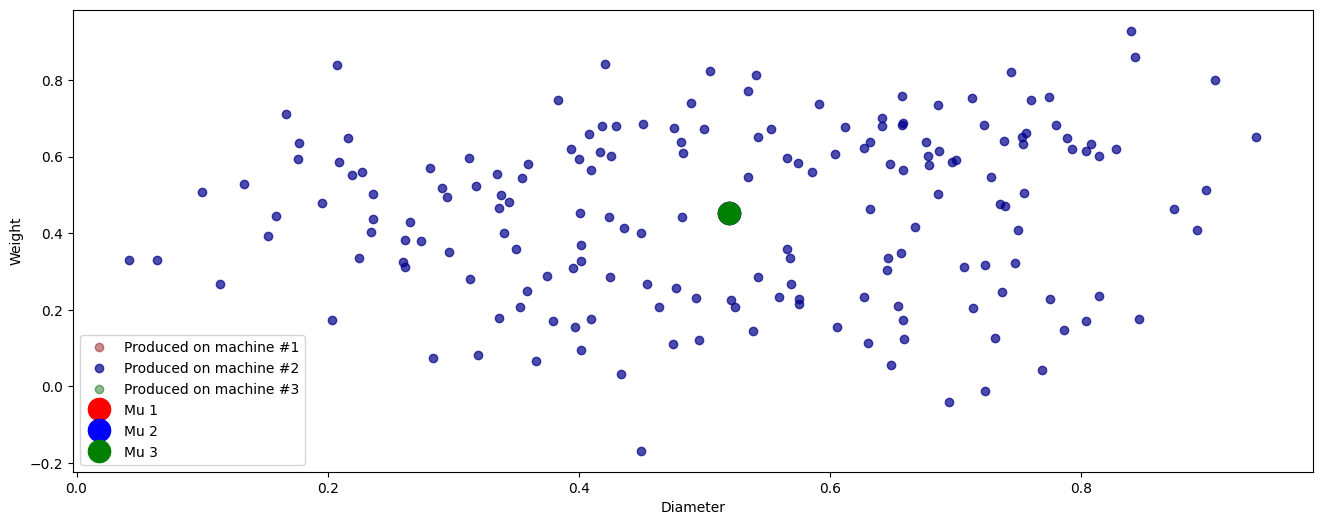

Итерация № 6
Матрица значений математических ожиданий
[[0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]]
Матрица значений стандартных отклонений
[[[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]]
Доля правильно распознанных изделий
0.399


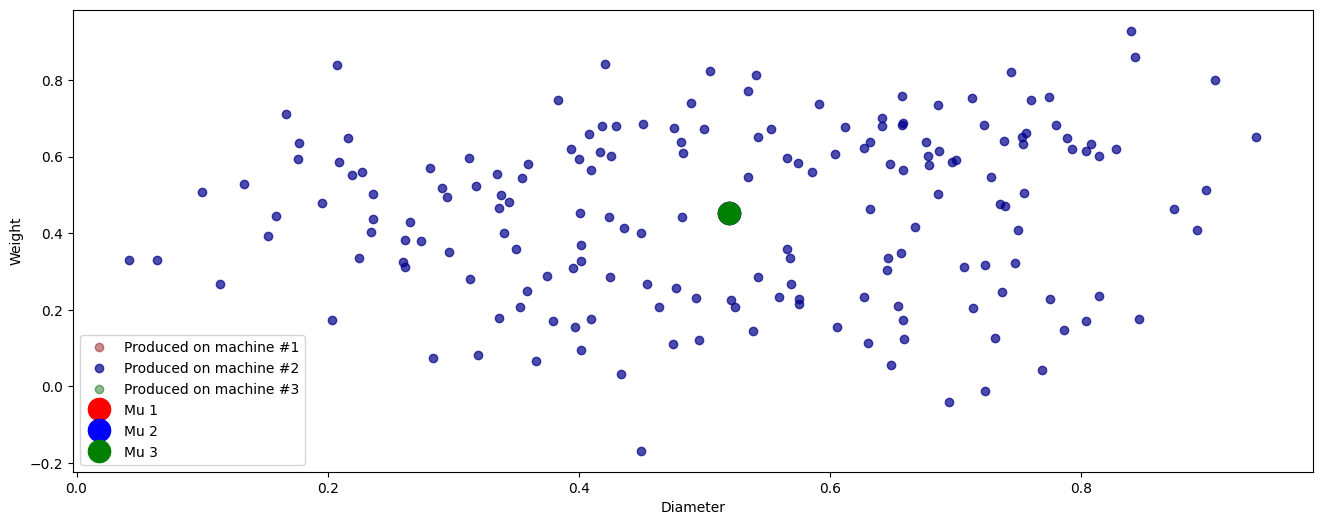

Итерация № 7
Матрица значений математических ожиданий
[[0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]]
Матрица значений стандартных отклонений
[[[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]]
Доля правильно распознанных изделий
0.382


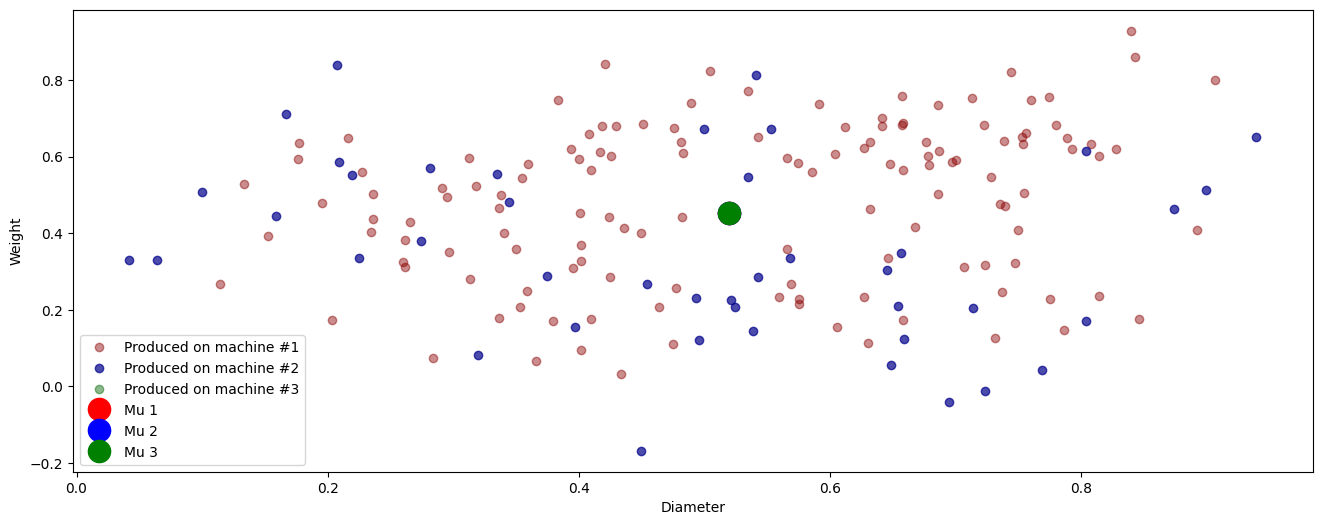

Итерация № 8
Матрица значений математических ожиданий
[[0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]]
Матрица значений стандартных отклонений
[[[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]]
Доля правильно распознанных изделий
0.343


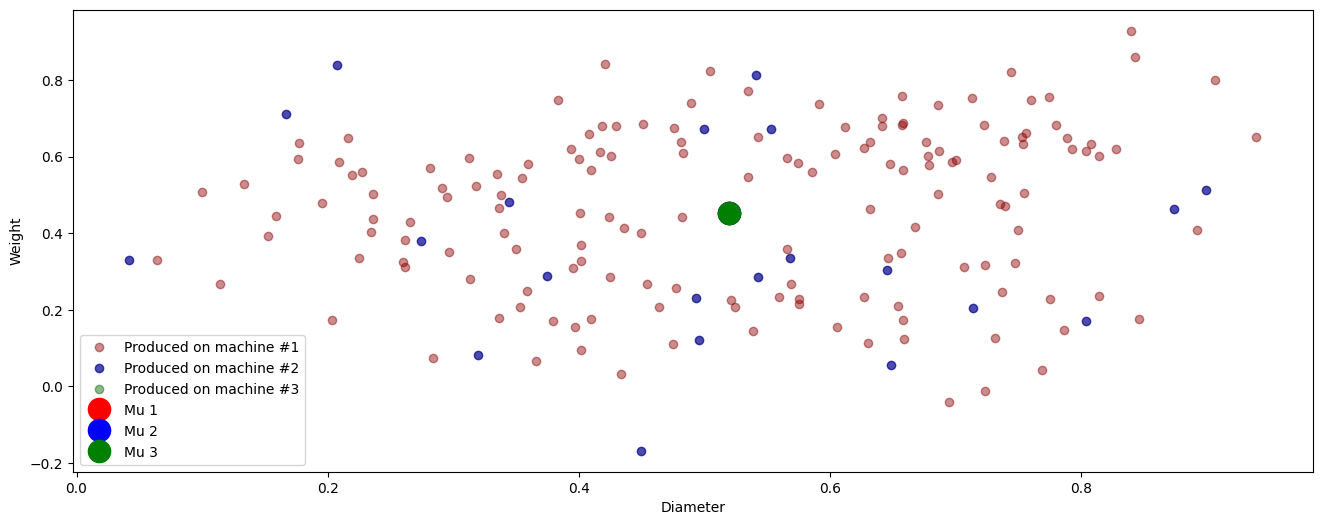

Итерация № 9
Матрица значений математических ожиданий
[[0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]]
Матрица значений стандартных отклонений
[[[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]]
Доля правильно распознанных изделий
0.337


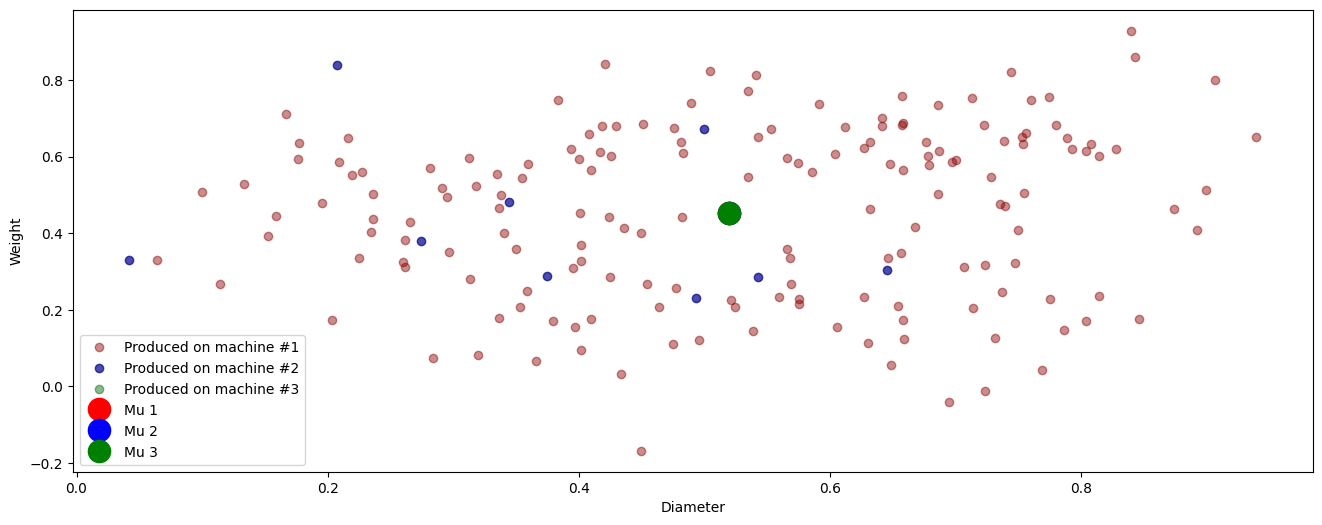

Итерация № 10
Матрица значений математических ожиданий
[[0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]]
Матрица значений стандартных отклонений
[[[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]]
Доля правильно распознанных изделий
0.331


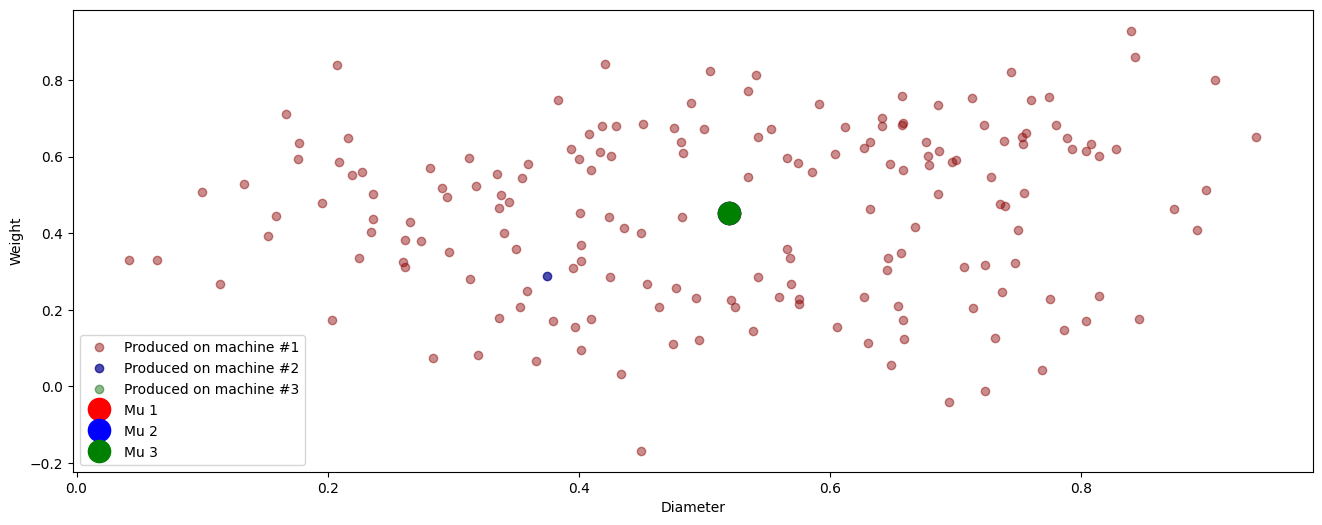

Итерация № 11
Матрица значений математических ожиданий
[[0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]]
Матрица значений стандартных отклонений
[[[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]]
Доля правильно распознанных изделий
0.331


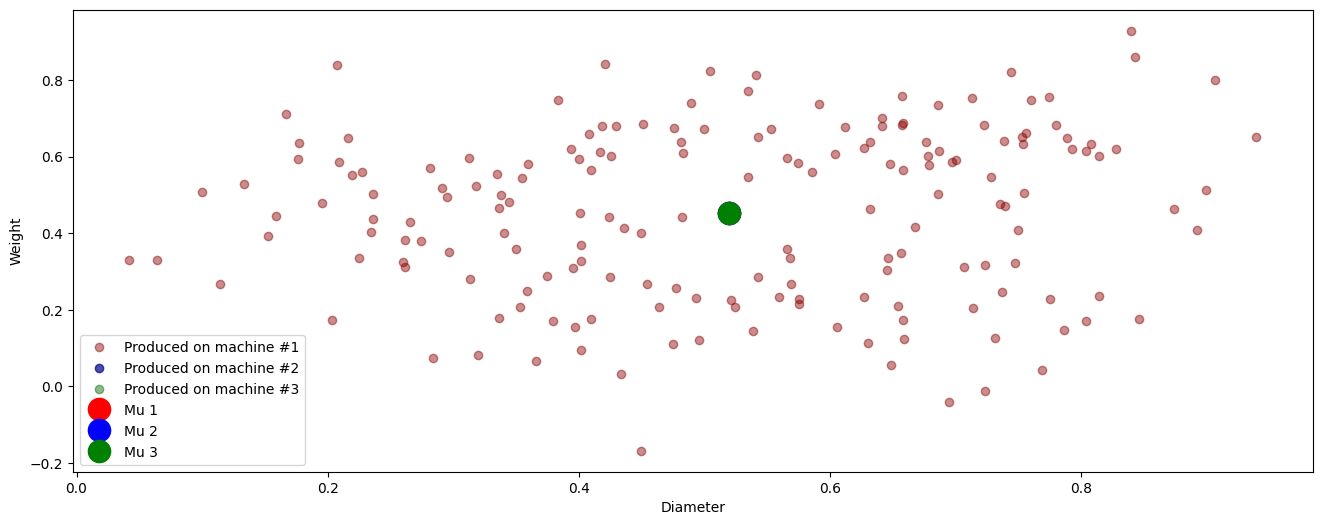

Итерация № 12
Матрица значений математических ожиданий
[[0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]]
Матрица значений стандартных отклонений
[[[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]]
Доля правильно распознанных изделий
0.331


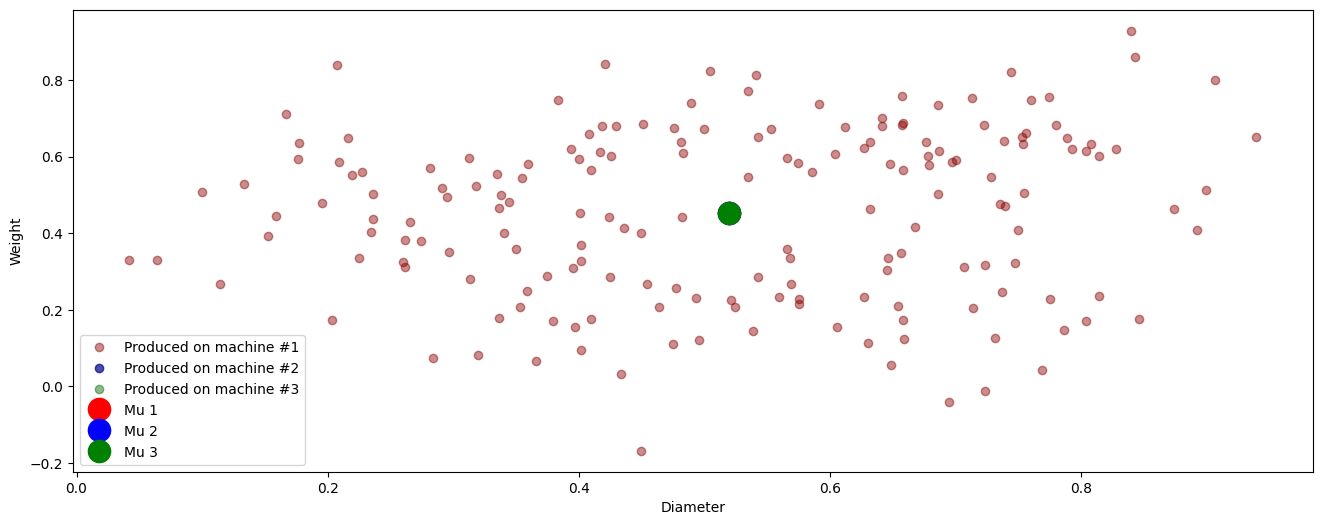

Итерация № 13
Матрица значений математических ожиданий
[[0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]]
Матрица значений стандартных отклонений
[[[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]]
Доля правильно распознанных изделий
0.152


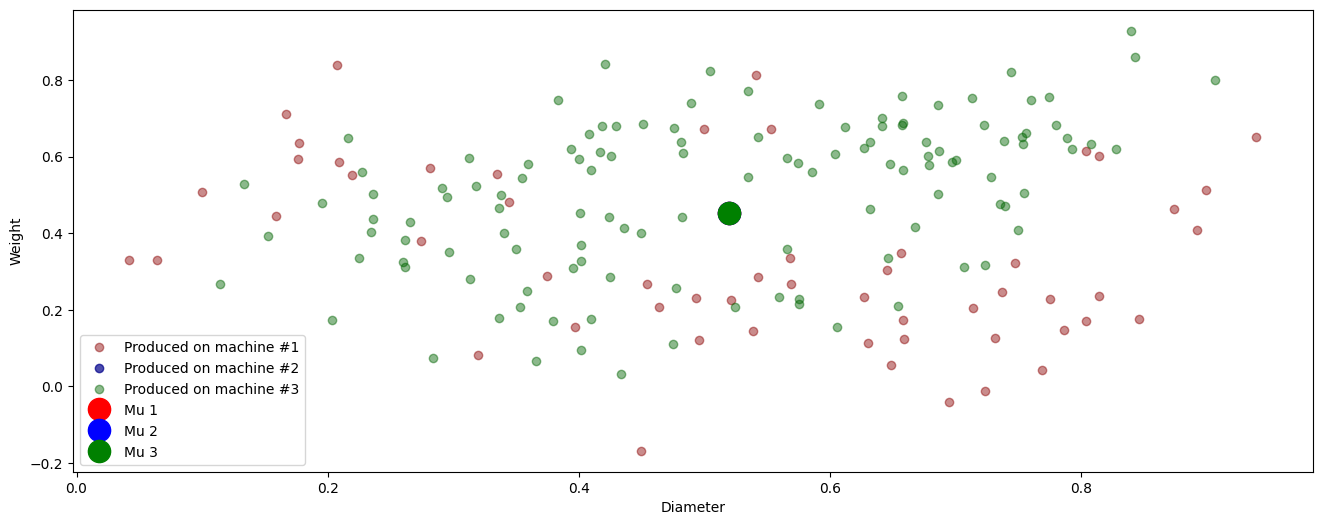

Итерация № 14
Матрица значений математических ожиданий
[[0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]]
Матрица значений стандартных отклонений
[[[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]]
Доля правильно распознанных изделий
0.41


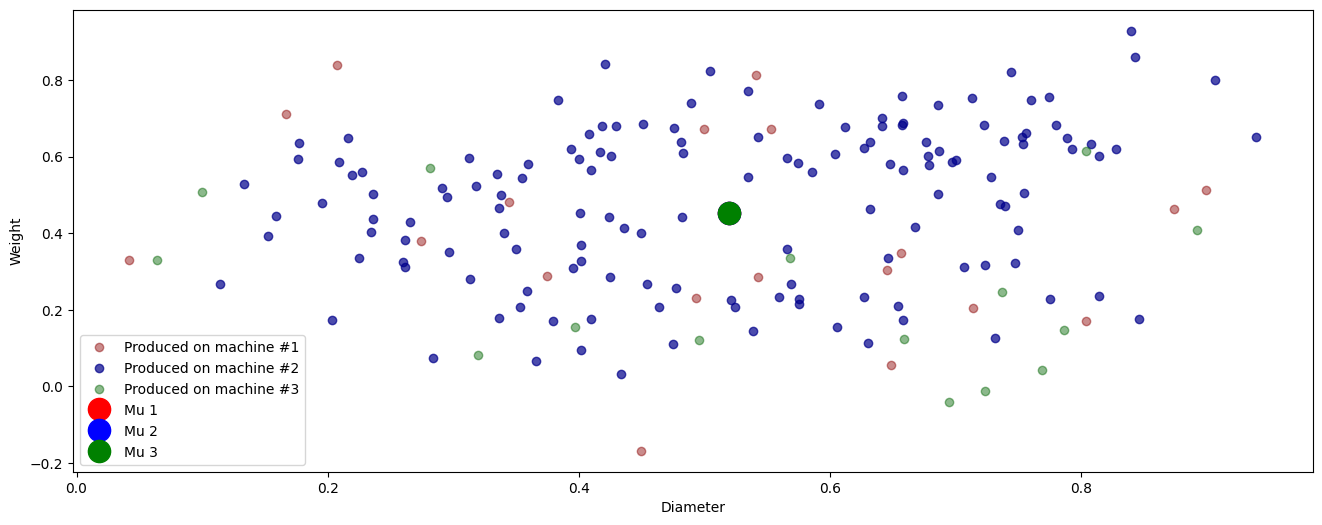

Итерация № 15
Матрица значений математических ожиданий
[[0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]
 [0.51994963 0.45322156 0.31494953]]
Матрица значений стандартных отклонений
[[[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]

 [[0.20851767 0.07357579 0.13743488]
  [0.07357579 0.22253082 0.        ]
  [0.13743488 0.         0.18140799]]]
Доля правильно распознанных изделий
0.376


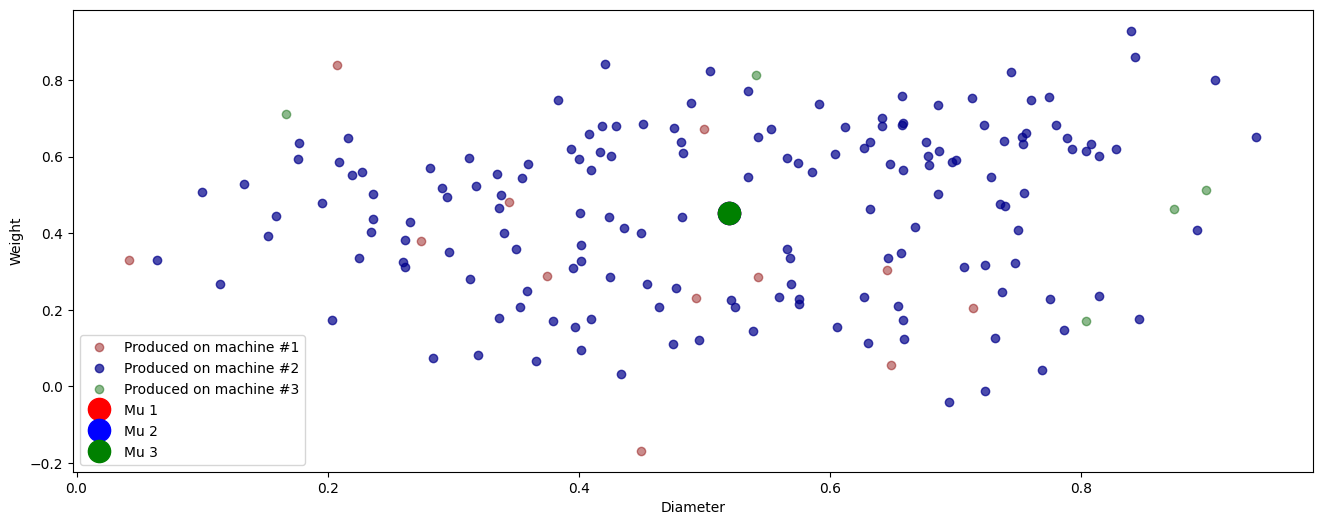

In [3]:
# сформируем исходные условия
counts_class = df.target.value_counts()
# количество строк с прарметрами вина класса №1 (кластер 1)
N1 = counts_class[0]
# количество строк с прарметрами вина класса №2 (кластер 2)
N2 = counts_class[1]
# количество строк с прарметрами вина класса №3 (кластер 3)
N3 = counts_class[2]
# суммарное количество строк с параметрами вина
N = N1 + N2 + N3

# количество классов вина
k = 3
# признаки для классификации
feature1 = 'alcohol'
feature2 = 'total_phenols'
feature3 = 'color_intensity'

# нормализуем данные под отрезок [0;1]
df[feature1] = (df[feature1] - df[feature1].min()) / (df[feature1].max() - df[feature1].min())
df[feature2] = (df[feature2] - df[feature2].min()) / (df[feature2].max() - df[feature2].min())
df[feature3] = (df[feature3] - df[feature3].min()) / (df[feature3].max() - df[feature3].min())

# разделяем данные по классам
df1 = df.loc[df['target'] == 0]
df2 = df.loc[df['target'] == 1]
df3 = df.loc[df['target'] == 2]

# признаки класса №1
mu_samples_1_1 = df1[feature1].mean()
mu_samples_1_2 = df1[feature2].mean()
mu_samples_1_3 = df1[feature3].mean()


# признаки класса №2
mu_samples_2_1 = df2[feature1].mean()
mu_samples_2_2 = df2[feature2].mean()
mu_samples_2_3 = df2[feature3].mean()

# признаки класса №3
mu_samples_3_1 = df3[feature1].mean()
mu_samples_3_2 = df3[feature2].mean()
mu_samples_3_3 = df3[feature3].mean()

# стандартное отклонение признаков класса №1
sigma_samples_1_1 = df1[feature1].std()
sigma_samples_1_2 = df1[feature2].std()
sigma_samples_1_3 = df1[feature3].std()

# стандартное отклонение признаков класса №2
sigma_samples_2_1 = df2[feature1].std()
sigma_samples_2_2 = df2[feature2].std()
sigma_samples_2_3 = df2[feature3].std()

# стандартное отклонение признаков класса №3
sigma_samples_3_1 = df3[feature1].std()
sigma_samples_3_2 = df3[feature2].std()
sigma_samples_3_3 = df3[feature3].std()

X = np.zeros((N, 3))

np.random.seed(seed=42)
# инициализируем данные по винам класса №1
X[:N1, 0] = np.random.normal(loc=mu_samples_1_1, scale=sigma_samples_1_1, size=N1)
X[:N1, 1] = np.random.normal(loc=mu_samples_1_2, scale=sigma_samples_1_2, size=N1)
X[:N1, 2] = np.random.normal(loc=mu_samples_1_3, scale=sigma_samples_1_3, size=N1)
# инициализируем данные по винам класса №2
X[N1:N2+N1, 0] = np.random.normal(loc=mu_samples_2_1, scale=sigma_samples_2_1, size=N2)
X[N1:N2+N1, 1] = np.random.normal(loc=mu_samples_2_2, scale=sigma_samples_2_2, size=N2)
X[N1:N2+N1, 2] = np.random.normal(loc=mu_samples_2_3, scale=sigma_samples_2_3, size=N2)
# инициализируем данные по винам класса №3
X[N-N3:N, 0] = np.random.normal(loc=mu_samples_3_1, scale=sigma_samples_3_1, size=N3)
X[N-N3:N, 1] = np.random.normal(loc=mu_samples_3_2, scale=sigma_samples_3_2, size=N3)
X[N-N3:N, 2] = np.random.normal(loc=mu_samples_3_3, scale=sigma_samples_3_3, size=N3)

# зафиксируем количество признаков
m = X.shape[1]

# зафиксируем количество объектов
n = X.shape[0]

# зафиксируем правильные ответы для оценки качества алгоритма (в обучении не используется)
y = np.zeros((N))
y[:N1] = np.array((1))
y[N1:N1+N2] = np.array((2))
y[N-N3:N] = np.array((3))

# инициализируем априорную вероятность извлечь вино класса №1, №2 и №3
w = np.array([float(1./k), float(1./k), float(1./k)])

np.random.seed(seed = None)
# инициализируем средние признаков (запишем в формате матрицы)
mu  = np.array(
   (np.mean(X[np.random.choice(n, int(n/k))], axis = 0), np.mean(X[np.random.choice(n, int(n/k))], axis = 0), np.mean(X[np.random.choice(n, int(n/k))], axis = 0)))
#mu = np.array(([mu_samples_1_1, mu_samples_1_2, mu_samples_1_3],[mu_samples_2_1, mu_samples_2_2, mu_samples_2_3], [mu_samples_3_1, mu_samples_3_2, mu_samples_3_3]))

# инициализируем стандартные отклонения признаков (запишем в формате матрицы ковариации)
sigma = np.array(([10**6., 0., 0.],[0., 10**6., 0.], [0., 0., 10**6.], [10**6., 0., 0.],[0., 10**6., 0.], [0., 0., 10**6.], [10**6., 0., 0.],[0., 10**6., 0.], [0., 0., 10**6.]))
#sigma = np.array(([sigma_samples_1_1, 0., 0.],[0., sigma_samples_1_2, 0.], [0., 0., sigma_samples_1_3], 
#                  [sigma_samples_2_1, 0., 0.],[0., sigma_samples_2_2, 0.], [0., 0., sigma_samples_2_3],
#                  [sigma_samples_3_1, 0., 0.],[0., sigma_samples_3_2, 0.], [0., 0., sigma_samples_3_3]))
sigma = sigma.reshape(k, m, m)

# выберем количество итераций EM-алгоритма
steps = 15
# запустим цикл EM-алгоритма
for i in range(steps):
    proba_xi = e_step(X, k, m, n, w, mu, sigma)
    w, mu, sigma = m_step(X, proba_xi,N)
    X1_new_ind, X2_new_ind, X3_new_ind, X_answers = x_new(proba_xi)
    print('Итерация №', i+1)
    print('Матрица значений математических ожиданий')
    print(mu)
    print('Матрица значений стандартных отклонений')
    print(sigma)
    print('Доля правильно распознанных изделий')
    print(round(accuracy_score(y, X_answers),3))
    
    plt.figure(figsize=(16, 6))  
    plt.plot(
        X[X1_new_ind,0], X[X1_new_ind,1], 'o', alpha = 0.45, color='darkred', label = 'Produced on machine #1')
    plt.plot(
        X[X2_new_ind,0], X[X2_new_ind,1], 'o', alpha = 0.7, color = 'darkblue', label = 'Produced on machine #2')
    plt.plot(
        X[X3_new_ind,0], X[X3_new_ind,1], 'o', alpha = 0.45, color = 'darkgreen', label = 'Produced on machine #3')
    plt.plot(mu[0][0], mu[0][1], 'o', markersize = 16, color = 'red', label = 'Mu 1')
    plt.plot(mu[1][0], mu[1][1], 'o',  markersize = 16, color = 'blue', label = 'Mu 2')
    plt.plot(mu[2][0], mu[2][1], 'o',  markersize = 16, color = 'green', label = 'Mu 3')
    plt.xlabel('Diameter')
    plt.ylabel('Weight')
    plt.legend()
    plt.show()

Как видно, EM-классификатор работает и разделяет классы вина (хоть за первые 15 шагов и с достаточно низкой точностью).
Теперь напишу функцию FullEM, в которую буду подавать датасет и названия признаков. Функция же будет выполнять функции e_step() и m_step(), пока не будет соблюдено условие сходимости - доля правильных ответов не достигнет хотя бы 85%.
Затем не используя деление выборки на train-test (так как обучение без учителя), проганю модифицированный EM-алгоритм 
и посчитюе метрики точности классификации(долю правильных ответов, полноту и точность по классам, а также F-меру).

Итерация № 2
Доля правильно распознанных изделий
0.86


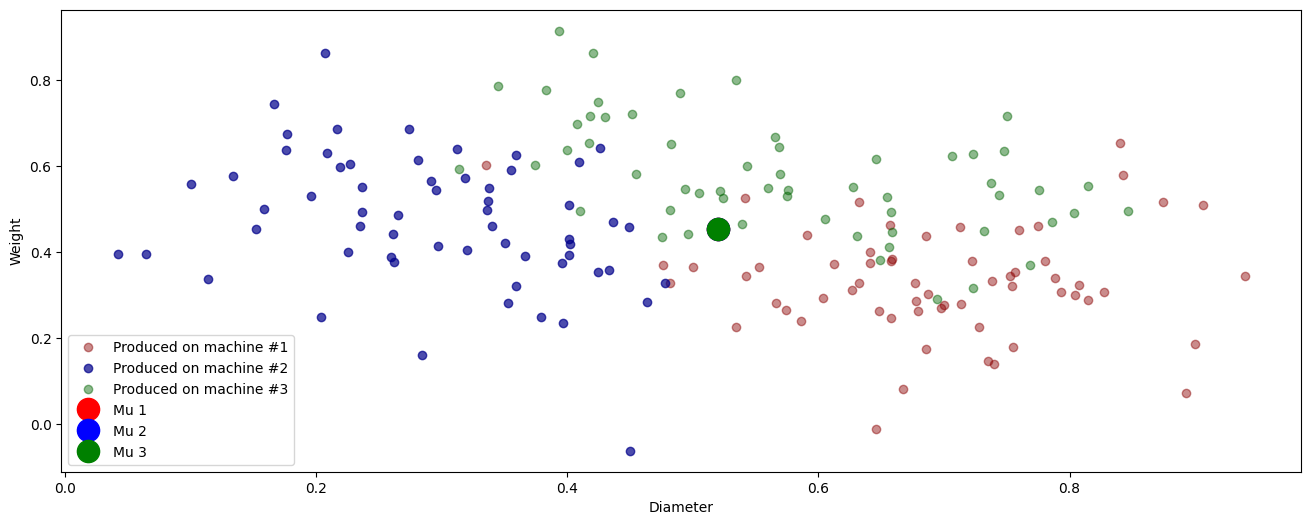

Доля правильных ответов алгоритма -  0.86 

Точностью (precision) класса №1 -  0.9661016949152542
Полнота (recall) класса №1 -  0.9344262295081968
F-мера класса №1 -  0.95 

Точностью (precision) класса №2 -  0.7605633802816901
Полнота (recall) класса №2 -  0.9
F-мера класса №2 -  0.8244274809160305 

Точностью (precision) класса №3 -  0.875
Полнота (recall) класса №3 -  0.7368421052631579
F-мера класса №3 -  0.7999999999999999 



In [17]:
def FullEM(data, features):
    counts_class = data.target.value_counts()
    N1 = counts_class[0]
    N2 = counts_class[1]
    N3 = counts_class[2]
    N = N1 + N2 + N3
    k = 3

    feature1 = features[0]
    feature2 = features[1]
    feature3 = features[2]
    
    df[feature1] = (df[feature1] - df[feature1].min()) / (df[feature1].max() - df[feature1].min())
    df[feature2] = (df[feature2] - df[feature2].min()) / (df[feature2].max() - df[feature2].min())
    df[feature3] = (df[feature3] - df[feature3].min()) / (df[feature3].max() - df[feature3].min())
    
    df1 = df.loc[df['target'] == 0]
    df2 = df.loc[df['target'] == 1]
    df3 = df.loc[df['target'] == 2]
    
    mu_samples_1_1 = df1[feature1].mean()
    mu_samples_1_2 = df1[feature2].mean()
    mu_samples_1_3 = df1[feature3].mean()
    
    mu_samples_2_1 = df2[feature1].mean()
    mu_samples_2_2 = df2[feature2].mean()
    mu_samples_2_3 = df2[feature3].mean()
    
    mu_samples_3_1 = df3[feature1].mean()
    mu_samples_3_2 = df3[feature2].mean()
    mu_samples_3_3 = df3[feature3].mean()
    
    sigma_samples_1_1 = df1[feature1].std()
    sigma_samples_1_2 = df1[feature2].std()
    sigma_samples_1_3 = df1[feature3].std()
    
    sigma_samples_2_1 = df2[feature1].std()
    sigma_samples_2_2 = df2[feature2].std()
    sigma_samples_2_3 = df2[feature3].std()
    
    sigma_samples_3_1 = df3[feature1].std()
    sigma_samples_3_2 = df3[feature2].std()
    sigma_samples_3_3 = df3[feature3].std()
    
    X = np.zeros((N, 3))

    np.random.seed(seed=42)
    X[:N1, 0] = np.random.normal(loc=mu_samples_1_1, scale=sigma_samples_1_1, size=N1)
    X[:N1, 1] = np.random.normal(loc=mu_samples_1_2, scale=sigma_samples_1_2, size=N1)
    X[:N1, 2] = np.random.normal(loc=mu_samples_1_3, scale=sigma_samples_1_3, size=N1)
    X[N1:N2+N1, 0] = np.random.normal(loc=mu_samples_2_1, scale=sigma_samples_2_1, size=N2)
    X[N1:N2+N1, 1] = np.random.normal(loc=mu_samples_2_2, scale=sigma_samples_2_2, size=N2)
    X[N1:N2+N1, 2] = np.random.normal(loc=mu_samples_2_3, scale=sigma_samples_2_3, size=N2)
    X[N-N3:N, 0] = np.random.normal(loc=mu_samples_3_1, scale=sigma_samples_3_1, size=N3)
    X[N-N3:N, 1] = np.random.normal(loc=mu_samples_3_2, scale=sigma_samples_3_2, size=N3)
    X[N-N3:N, 2] = np.random.normal(loc=mu_samples_3_3, scale=sigma_samples_3_3, size=N3)
    
    m = X.shape[1]
    n = X.shape[0]
    
    y = np.zeros((N))
    y[:N1] = np.array((1))
    y[N1:N1+N2] = np.array((2))
    y[N-N3:N] = np.array((3))
    
    w = np.array([float(1./k), float(1./k), float(1./k)])
    
    np.random.seed(seed = None)
    mu  = np.array(
       (np.mean(X[np.random.choice(n, int(n/k))], axis = 0), np.mean(X[np.random.choice(n, int(n/k))], axis = 0), np.mean(X[np.random.choice(n, int(n/k))], axis = 0)))
    degree = 10**4
    sigma = np.array(([degree, 0., 0.],[0., degree, 0.], [0., 0., degree], [degree, 0., 0.],[0., degree, 0.], [0., 0., degree], [degree, 0., 0.],[0., degree, 0.], [0., 0., degree]))

    sigma = sigma.reshape(k, m, m)
    
    i = 1
    proba_xi = e_step(X, k, m, n, w, mu, sigma)
    w, mu, sigma = m_step(X, proba_xi,N)
    X1_new_ind, X2_new_ind, X3_new_ind, X_answers = x_new(proba_xi)
    while round(accuracy_score(y, X_answers),3) < 0.85:
        i += 1
        proba_xi = e_step(X, k, m, n, w, mu, sigma)
        w, mu, sigma = m_step(X, proba_xi,N)
        X1_new_ind, X2_new_ind, X3_new_ind, X_answers = x_new(proba_xi)
    print('Итерация №', i+1)
    print('Доля правильно распознанных изделий')
    print(round(accuracy_score(y, X_answers),3))
    
    plt.figure(figsize=(16, 6))  
    plt.plot(
        X[X1_new_ind,0], X[X1_new_ind,1], 'o', alpha = 0.45, color='darkred', label = 'Produced on machine #1')
    plt.plot(
        X[X2_new_ind,0], X[X2_new_ind,1], 'o', alpha = 0.7, color = 'darkblue', label = 'Produced on machine #2')
    plt.plot(
        X[X3_new_ind,0], X[X3_new_ind,1], 'o', alpha = 0.45, color = 'darkgreen', label = 'Produced on machine #3')
    plt.plot(mu[0][0], mu[0][1], 'o', markersize = 16, color = 'red', label = 'Mu 1')
    plt.plot(mu[1][0], mu[1][1], 'o',  markersize = 16, color = 'blue', label = 'Mu 2')
    plt.plot(mu[2][0], mu[2][1], 'o',  markersize = 16, color = 'green', label = 'Mu 3')
    plt.xlabel('Diameter')
    plt.ylabel('Weight')
    plt.legend()
    plt.show()

    X_answers = np.array(X_answers)
    # Посчитаем метрики
    X_1 = (X_answers==1)
    X_2 = (X_answers==2)
    X_3 = (X_answers==3)
    Y_1 = (y==1)
    Y_2 = (y==2)
    Y_3 = (y==3)
    print('Доля правильных ответов алгоритма - ', round(accuracy_score(y, X_answers),3), '\n')
    print('Точностью (precision) класса №1 - ', precision_score(X_1, Y_1))
    print('Полнота (recall) класса №1 - ', recall_score(X_1, Y_1))
    print('F-мера класса №1 - ', f1_score(X_1, Y_1), '\n')
    
    
    print('Точностью (precision) класса №2 - ', precision_score(X_2, Y_2))
    print('Полнота (recall) класса №2 - ', recall_score(X_2, Y_2))
    print('F-мера класса №2 - ', f1_score(X_2, Y_2), '\n')
    
    print('Точностью (precision) класса №3 - ', precision_score(X_3, Y_3))
    print('Полнота (recall) класса №3 - ', recall_score(X_3, Y_3))
    print('F-мера класса №3 - ', f1_score(X_3, Y_3), '\n')


data = load_wine()
df=pd.DataFrame(data=np.c_[data['data'],data['target']],columns=data['feature_names']+['target'])

FullEM(df, ['alcohol','alcalinity_of_ash', 'flavanoids'])

Как видно, доля правильных ответов равна 0,86 (но алгоритм выдает такую точность или с n-ой попытки запуска или спустя несколько десятков минут обучения)
При этом точность (доля правильных ответов модели в пределах класса или доля объектов действительно принадлежащих данному классу относительно всех объектов которые система отнесла к этому классу.) во втором классе всего 76%, зато в первом целых 96,6% что очень хорошо в моем случае
Полнота (доля истинно положительных классификаций) по сути показывает возможность алгоритма обнаруживать данный класс вообще. И как можно видеть первый и второй класс мы можем обнаруживать с 90%+ вероятностью, тогда как третий всего 73,6%
F-мера представляет собой гармоническое среднее между точностью и полнотой. Она стремится к нулю, если точность или полнота стремится к нулю. И как мжно видеть F-мера наилучшая у первого класса, так как по полноте и точности он выигрывает у двух других. А вот второй и третий класс примерно равносильны.

Использую GaussianMixture из sklearn и также посчитаю метрикие?

In [26]:
from sklearn.mixture import GaussianMixture

X = []
y = []
for index, row in df.iterrows():
    X.append([row[feature1], row[feature2], row[feature3]])
    y.append(row['target'])
X = np.array(X)
y = np.array(y)
gm = GaussianMixture(n_components=3).fit(X)
X_answers = gm.predict(X)
X_1 = (X_answers==0)
X_2 = (X_answers==1)
X_3 = (X_answers==2)
Y_1 = (y==0)
Y_2 = (y==1)
Y_3 = (y==2)
print('Доля правильных ответов алгоритма - ', round(accuracy_score(y, X_answers),3), '\n')
print('Точностью (precision) класса №1 - ', precision_score(X_1, Y_1))
print('Полнота (recall) класса №1 - ', recall_score(X_1, Y_1))
print('F-мера класса №1 - ', f1_score(X_1, Y_1), '\n')


print('Точностью (precision) класса №2 - ', precision_score(X_2, Y_2))
print('Полнота (recall) класса №2 - ', recall_score(X_2, Y_2))
print('F-мера класса №2 - ', f1_score(X_2, Y_2), '\n')

print('Точностью (precision) класса №3 - ', precision_score(X_3, Y_3))
print('Полнота (recall) класса №3 - ', recall_score(X_3, Y_3))
print('F-мера класса №3 - ', f1_score(X_3, Y_3), '\n')


Доля правильных ответов алгоритма -  0.899 

Точностью (precision) класса №1 -  1.0
Полнота (recall) класса №1 -  0.8428571428571429
F-мера класса №1 -  0.9147286821705426 

Точностью (precision) класса №2 -  0.7746478873239436
Полнота (recall) класса №2 -  1.0
F-мера класса №2 -  0.873015873015873 

Точностью (precision) класса №3 -  0.9583333333333334
Полнота (recall) класса №3 -  0.8679245283018868
F-мера класса №3 -  0.910891089108911 



Видно, что в данном случае классификация более точна, хоть и превосходит прошлую реализацию менее чем на 5%. Практически равна 90%
В данном случае точность у первого класса равна 100%, а третьего класса 95%, что очень хорошо. Но вот точность второго класса "хромает".
Полнота второго класса равна 100% (что хорошо), а первого и третьего примерно одинакова.
F-мера же примерно одинакова у всех классов и, следовательно, у всех классов примерно одинаковый баланс между точностью и полнотой.
*Иногда при запуске вероятность может быть около 0.33 или 0.05 по причине того, что классификатор по другому нумерует классы и нумерация не совпадает с датасетовской нумерация (нужно просто поменять номера в y_true массиве и процент пересчитается в этот же, около 90%)

Если говорить про точность и время работы, то выигрывает реализация sklearn, хоть ее точность и не критично выше точности "самописного" алгоритма.